In [2]:
from numpy import vstack,load
from numpy.linalg import norm
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import Adam
from torch.nn import MSELoss
from torch.optim import lr_scheduler
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import time
import copy
from pandas import DataFrame
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class CyclicDataset(Dataset):
    def __init__(self, path):
        self.X = load(path+'_data.npy')
        self.y = load(path+'_label.npy')

    def __len__(self):
        return len(self.X)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

    def split_data(self, split_ratio=0.1):
        val_size = round(split_ratio * len(self.X))
        train_size = len(self.X) - val_size
        return random_split(self, [train_size, val_size])

In [8]:
class CyclicMLP(Module):
    def __init__(self, n_inputs, hidden_dim, n_outputs):
        super(CyclicMLP, self).__init__()

        self.hidden1 = Linear(n_inputs, hidden_dim)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        
        self.hidden2 = Linear(hidden_dim, hidden_dim)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()

        self.hidden3 = Linear(hidden_dim, n_outputs)
        xavier_uniform_(self.hidden3.weight)
        
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)

        X = self.hidden2(X)
        X = self.act2(X)

        X = self.hidden3(X)
        return X

In [23]:
def train_model(train_dl, val_dl, model, epochs=100, lr=0.01, weight_decay=1e-4, save_path='cyclic_best_model.pth'):

    start = time.time()
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        running_tloss = 0.0
        model.train(True)
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.float(), targets.float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_tloss += loss.item()
        running_tloss /= (i+1)
        running_vloss = 0.0
        model.train(False)
        for i, (inputs, targets) in enumerate(val_dl):
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_vloss += loss
        running_vloss /= (i+1)
        print('Train Loss: {} ; Valid Loss: {}'.format(running_tloss, running_vloss))
        torch.save(model, save_path)
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    
    return model

In [29]:
import math
def evaluate_model(test_dl, model):
    preds = []
    actuals = []

    for (i, (inputs, targets)) in enumerate(test_dl):
        inputs, targets = inputs.float(), targets.float()
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        preds.append(yhat)
        actuals.append(actual)
    
    preds, actuals = vstack(preds), vstack(actuals)
    
    cosine_errors = 1-(preds*actuals).sum(axis=1)/(norm(preds, axis=1)*norm(actuals, axis=1))
    
    metrics = {'mae': mean_absolute_error(actuals, preds),
               'mse': mean_squared_error(actuals, preds),
               'mce': cosine_errors.mean(),
               'max_ce': cosine_errors.max(),
               'r2': r2_score(actuals, preds)}
    
    return metrics, preds, actuals

In [7]:
def prepare_cyclic_dataset(path):
    train_dataset, test_dataset = CyclicDataset(path+'_train'), CyclicDataset(path+'_test')
    train, val = train_dataset.split_data(split_ratio=0.1)
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val_dl = DataLoader(val, batch_size=1024, shuffle=False)
    test_dl = DataLoader(test_dataset, batch_size=1024, shuffle=False)
    return train_dl, val_dl, test_dl

In [10]:
def predict(row, model):
    row = Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat   

In [14]:
train_dl, val_dl, test_dl = prepare_cyclic_dataset('/Users/shivampatel/UCLA/KaoLab/neural-robotic-arm/data/processed/cyclic_traj_simple')

In [15]:
model = CyclicMLP(8,50,4)

In [25]:
train_model(train_dl,
            val_dl,
            model, 
            save_path='/Users/shivampatel/UCLA/KaoLab/neural-robotic-arm/models/cyclic_model_simple.pkl', 
            epochs=30, 
            lr=0.01)

Epoch 1/30
----------
Train Loss: 0.00043883063840874793 ; Valid Loss: 0.0004153003974352032
Epoch 2/30
----------
Train Loss: 0.0004348454366648425 ; Valid Loss: 0.00043556082528084517
Epoch 3/30
----------
Train Loss: 0.00043889911182325175 ; Valid Loss: 0.0005013048648834229
Epoch 4/30
----------
Train Loss: 0.00043839630532264593 ; Valid Loss: 0.00041723495814949274
Epoch 5/30
----------
Train Loss: 0.0004363067557547354 ; Valid Loss: 0.0003876323171425611
Epoch 6/30
----------
Train Loss: 0.000439248385178681 ; Valid Loss: 0.00044794532004743814
Epoch 7/30
----------
Train Loss: 0.00043764345114673893 ; Valid Loss: 0.00042923071305267513
Epoch 8/30
----------
Train Loss: 0.00043664142348793876 ; Valid Loss: 0.0004614810459315777
Epoch 9/30
----------
Train Loss: 0.00043474012437851967 ; Valid Loss: 0.0004336050769779831
Epoch 10/30
----------
Train Loss: 0.0004384261159892957 ; Valid Loss: 0.0004615863726940006
Epoch 11/30
----------
Train Loss: 0.0004413353896156991 ; Valid Loss:

CyclicMLP(
  (hidden1): Linear(in_features=8, out_features=50, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=50, out_features=4, bias=True)
)

In [34]:
results = evaluate_model(test_dl, model)
model_metrics = results[0]
metrics_df = DataFrame.from_dict(model_metrics, orient='index', columns=['metric'])
metrics_df.index.name = 'metric_type'
metrics_df.reset_index(inplace=True)
# metrics_df.to_csv('metrics.csv', index=False)

In [35]:
metrics_df

,metric_type,metric
0,mae,0.010236
1,mse,0.000459
2,mce,0.000904
3,max_ce,0.009084
4,r2,0.705005


## Visualization

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

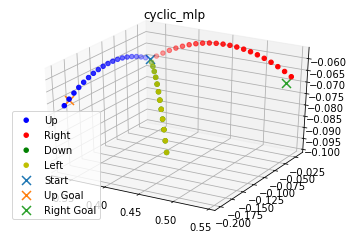

In [24]:
init = np.array([0.335, -0.02, -0.07])
goals = np.array([[0.335, -0.19, -0.07], [0.537, -0.02, -0.07]])

dirs = torch.Tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
dir_names = ['Up', 'Right', 'Down', 'Left']

model = torch.load('/home3/shivam/neural-robotic-arm/models/cyclic_model_simple.pkl')
model.eval()

step = 1e-2

points = {0:[],1:[],2:[],3:[]}

for i in range(4):
    curr = init.copy()
    d_ab = np.linalg.norm(curr-goals, axis=1).min()
    limit = int(d_ab/(2*step))
    it = 0
    while(True):
        direction = predict(np.hstack((dirs[i,:],curr,np.array([0.08]))), model)
        curr += step*(direction[0][:-1]/np.linalg.norm(direction[0][:-1]))
        points[i].append(curr.copy())
        new_d_ab = np.linalg.norm(curr-goals, axis=1).min()
        it += 1
        if(it > limit and new_d_ab > d_ab):
            break
        else:
            d_ab = new_d_ab

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = {0:[],1:[],2:[],3:[]}
ys = {0:[],1:[],2:[],3:[]}
zs = {0:[],1:[],2:[],3:[]}
c = {0:[],1:[],2:[],3:[]}
clrs = ['b','r','g','y']

for i in range(4):
    xs[i] = [x[0] for i, x in enumerate(points[i])]
    ys[i] = [x[1] for i, x in enumerate(points[i])]
    zs[i] = [x[2] for i, x in enumerate(points[i])]
    c[i] = [clrs[i]]*len(xs[i])
    ax.scatter(xs[i], ys[i], zs[i], c=c[i], label=dir_names[i])

ax.scatter(*list(init),marker='x',s=81,label='Start')
ax.scatter(*list(goals[0,:]),marker='x',s=81,label='Up Goal')
ax.scatter(*list(goals[1,:]),marker='x',s=81,label='Right Goal')

plt.legend()
plt.title('cyclic_mlp')
plt.savefig('/home3/shivam/neural-robotic-arm/reports/figures/cyclic_mlp.png')